<div>
<img src="https://www.ibm.com/blogs/bluemix/wp-content/uploads/2017/02/NLU.png", width=170, height=170, align='right'>  
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png", width = 90, height = 90, align = 'right', style="margin:left:2px 25px">
</div>

# Culture Transformation Jam 情感分析
本文演示基于情感词库对不同回答进行情感分析的方法。<br>
This notebook runs on Python 3.5 with Spark 2.1.

## 内容列表

1.[实现目标](#goal)  
2.[准备工作](#pre)   
　　2.1 [库安装](#library)  
　　2.2 [分析文件导入](#data)  
3.[数据探索](#basic)  
　　3.1 [各问题的回答数统计](#number)  
　　3.2 [参与者分类](#div)  
　　3.3 [参与者对各主题关注比较](#topic)    
4.[数据处理](#process)   
　　4.1 [数据清洗和转换](#clean)  
　　4.2 [SVM分类算法，对问题进行分类](#svm)  
　　4.3 [开放性问题过滤](#filter)  
5.[模型构建](#model)  
　　5.1 [中英文情感词、否定词、程度词库导入](#dict)  
　　5.2 [情感聚合](#sentiment)   
　　5.3 [一个具体问题的情感分数统计](#analysis) 

<a id='goal'></a>
# 1. 根据调查问题，实现以下目标：

- 统计各个问题的回答数，了解参与者感兴趣的问题
- 将参与者从不同维度进行分类，比较不同类别参与者关注主题的异同
- 识别出非发放型问题并对其每个回答进行情感分析
- 根据情感分析结果比较不同类别参与者情感倾向的异同

<a id='pre'></a>
# 2. 准备工作

<a id='library'></a>
### 2.1 库安装
- 包括：nltk、numpy、pandas、jieba、sklearn

In [276]:
#coding:utf-8
from io import StringIO
import requests
import json
import pandas as pd
import numpy as np
import jieba
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split  
from sklearn.svm import SVC 
import nltk

- 特殊的module：langconv.py文件用于繁体简体转换

In [277]:
from langconv import *

<a id='data'></a>
### 2.2 分析文件导入


部分问题截图

In [278]:
# The code was removed by DSX for sharing.

,﻿QuestionID,QuestionTitle,QuestionCreatedTime,AnswerID,AnswerText,AnswerCreateTime,Attr 1,Attr 2,Attr 3,Attr7,Attr 4,Attr 5,Attr 6,Position Title
0,026dffc3cfea402ca5f4c3a93c07f3b8,Do you like our new Agile Open Office?,2017-08-17 14:31,a1b6d9ed02fd4253850df574e1e6c9eb,Yes,2017-08-17 09:57,7,c,1,S0,a1,1,C0,Software Developer
1,1718f85eac0d416c99340c2688c31d5b,"David Kenny在上午的TownHall上说""Powerpoint is neithe...",2017-08-31 08:52,c2b9bcd7236b4714afa786e35736c52c,不能把所有问题都丢到公司来解决,2017-08-31 06:50,9,c,1,S0,a1,1,C3,Software Developer
2,b4b8c86e3727481198a19ee5308d1e81,如何才能在Lab工作的每一天都有好心情,2017-08-14 14:21,bfe1c5746a5e499cb18a787c47beb44e,"Have a harmonious, interesting and lovely team~",2017-08-16 06:37,2,c,1,S0,a0,0,C0,Software Developer


<a id='basic'></a>
# 3. 对数据进行基本的探索
本节针对回答数量进行统计分析，有关回答内容的分析见下一节

<a id='number'></a>
### 3.1 各问题的回答数统计

#### 回答数量最多的前10个问题

In [279]:
questionid=[]
count=[]
for i in range(0,len(data)):
    id=data[i][0]
    if id not in questionid:
        questionid.append(id)
        count.append(1)
    else:
        j=0
        while questionid[j]!=id:
            j+=1
        count[j]+=1

index=np.array(count).argsort()

print ('            QuestionId','                        Answer数量')
i=len(index)-1
while i>=len(index)-10:
    print(questionid[index[i]],'                  ',count[index[i]])
    i-=1        

            QuestionId                         Answer数量
78447fa96bd445a18af58575e0566a71                    51
026dffc3cfea402ca5f4c3a93c07f3b8                    40
301ff78db7e4448d9a61160b3a299f33                    38
1b86aa9b91164e3c85af675a0ab59341                    30
8d57d41da3c6454fb3a767e1bee55b12                    26
39254631ef254d9a9c8b66f171d721cd                    25
eeb51f1cb5ac4ad3a0d7004c4a567d5e                    22
339375145cdf4bc783c5661626b72626                    16
8c71fd457b3741289e54281a566c31b5                    16
a51b028fea374a118b8d1d5179c9e4c3                    14


#### 不同主题占比

In [280]:
# 读问题-主题文件
f=open("que_key.csv",'r',encoding='utf-8')
df=pd.read_csv(f)
df=np.array(df)

question_id= pd.read_csv(get_object_storage_file('MyHackathon', 'data2.csv'))
question_id.head()
question_id=np.array(question_id)

# 统计
labels1=[]
quants1=[]
i=1
while i<=10:
    idx=index[len(index)-i]
    i+=1
    quants1.append(count[idx])
    id=questionid[idx]
    j=0
    while question_id[j][1]!=id:
        j+=1
    labels1.append(df[j][1])
    
question_list = pd.DataFrame(labels1)
question_list['QUANTS'] = quants1
question_list['Percentage'] = question_list.QUANTS/question_list.QUANTS.sum()
question_list['Percentage'] = question_list.Percentage.apply(lambda x: format(x, '.2%'))
question_list.columns = ['LABELS','QUANTS','Percentage']
question_list['LABELS_2'] = [','.join(x.split(" ")[1:3]) for x in question_list.LABELS]



import brunel
%brunel data('question_list') bar color(Percentage) y(QUANTS)  polar stack label(LABELS_2)  legends(none)  tooltip(LABELS,QUANTS,Percentage) title("回答数量最多的Top 10主题") style('.label{font-size: 9pt;fill:#ffffff;text-shadow:none}') :: width=900, height=400


<IPython.core.display.Javascript object>

分析：
- 从上图中可以看出，与”小朋友 cdl 转变“相关的问题是回答数最多的，可见参与者对这些问题更感兴趣，关于工作的问题次之

<a id='div'></a>
### 3.2 参与者分类

#### 根据职位，对参与者进行分类

- 将所有职位分为Manager、Engineer、Specialist、Consultant和Other五大类
- 每一类包含的职业如下

In [281]:
# 对不同title的回答进行统计分析
x1=['Functional Manager','Offering Manager','People Manager','Product Manager','Project Manager','Software Release Manager','Solution Manager']
x2=['App Integ & Middleware Solutio','Application Architect','Business Analyst','Designer','Information Architect','Information Developer','Infrastructure Architect','Software Architect','Software Designer','Software Developer','Software Performance Analyst']
x3=['Administrative Staff Professio','Business Operations Specialist','Infrastructure Specialist','Software Test Specialist','Technical Support Professional']
x4=['Application Consultant','IT Management Consultant','Package Solution Consultant']
x5=['Compliance Audit & Risk Assure','Customer / Partner Engagement','Portals & Collaboration Sols S','Software Service Planner']
label=['Manager','Engineer','Specialist','Consultant','Other']

x=[]
x.append(x1)
x.append(x2)
x.append(x3)
x.append(x4)
x.append(x5)
for i in range(0,5):
    print (label[i],':')
    print (x[i])

Manager :
['Functional Manager', 'Offering Manager', 'People Manager', 'Product Manager', 'Project Manager', 'Software Release Manager', 'Solution Manager']
Engineer :
['App Integ & Middleware Solutio', 'Application Architect', 'Business Analyst', 'Designer', 'Information Architect', 'Information Developer', 'Infrastructure Architect', 'Software Architect', 'Software Designer', 'Software Developer', 'Software Performance Analyst']
Specialist :
['Administrative Staff Professio', 'Business Operations Specialist', 'Infrastructure Specialist', 'Software Test Specialist', 'Technical Support Professional']
Consultant :
['Application Consultant', 'IT Management Consultant', 'Package Solution Consultant']
Other :
['Compliance Audit & Risk Assure', 'Customer / Partner Engagement', 'Portals & Collaboration Sols S', 'Software Service Planner']


- 各职位回答问题数量统计

In [282]:
title=[]
question_id=[]
answer_id=[]
count=np.zeros(5)
for line in data:
    question_id.append(line[0])
    answer_id.append(line[3])
    tit=line[13]
    if tit in x1:
        title.append(0)
        count[0]+=1
    elif tit in x2:
        title.append(1)
        count[1]+=1
    elif tit in x3:
        title.append(2)
        count[2]+=1
    elif tit in x4:
        title.append(3)
        count[3]+=1
    elif tit in x5:
        title.append(4)
        count[4]+=1
    else:
        title.append(4)
        count[4]+=1
        
x=[]
y=[]
for i in range(0,5):
    x.append(label[i])
    y.append(count[i])
df_ans = pd.DataFrame()
df_ans['TYPE'] = x
df_ans['COUNT'] = y

%brunel data('df_ans') bar x(TYPE) y(COUNT)  label(COUNT) color(TYPE) sort(COUNT) tooltip(#all) stack style('.label{fill:white;text-shadow:none}') bar interaction(select:mouseover)   effect(enter:2000)  title("\n")  axes(y:2000:grid:"数量",x:10:"职位"):: width=800, height=300

<IPython.core.display.Javascript object>

分析：
- 图中可以看出，Specialist回答数最多、参与度最高，Engineer次之
- Manager参与度一般
- Consultant回答数最少，参与度最低

#### 根据属性，利用K-means聚类算法，对参与者进行分类

- 量化字符串属性：将Attr2从字母转化为与'a'的差值，Attr4、Attr6、Att7分别去掉字母前缀

In [283]:
# 量化字符串属性
features=[]
question_id=[]
answer_id=[]

for line in data:
    question_id.append(line[0])
    answer_id.append(line[3])
    feature=[]
    feature.append(line[6])
    feature.append(ord(line[7][0])-ord('a'))
    feature.append(line[8])
    feature.append(int(str(line[10])[1:]))
    feature.append(line[11])
    feature.append(int(str(line[12])[1:]))
    feature.append(int(str(line[9])[1:]))
    features.append(feature)

- 参数设置：以类簇平均半径为指标从[2,10]中选择最合适的k值

In [284]:
from sklearn.cluster import KMeans 
average=[]
# 从2~10中寻找最合适的k值，以类簇平均半径为指标
for k in range(2,11):
    clf = KMeans(n_clusters=k)
    s = clf.fit(features)
    sum=0
    for i in range(0,k):
        radius=0
        for j in range(0,len(clf.labels_)):
            if clf.labels_[j]==i:
                dis=np.linalg.norm(features[j]-clf.cluster_centers_[i])
                if dis>radius:
                    radius=dis
        sum+=radius
    average.append(sum/k)


import brunel
pd_tmp=pd.DataFrame(average,columns=['AVERAGE'])
pd_tmp['K']=range(2,11)
%brunel line x(K) y(AVERAGE)    

<IPython.core.display.Javascript object>

当K取值6时，类簇指标的下降趋势最快，所以K的正确取值应该是6，即根据属性将参与者分为6类

- 参与者类型特征统计

       attr1     attr2     attr3     attr4     attr5     attr6      attr7  \
0   3.825581  1.686047  1.000000  1.395349  0.337209  1.906977   1.418605   
1   6.060976  2.853659  0.536585  4.292683  0.500000  1.170732  16.463415   
2   3.834225  0.957219  0.807487  2.358289  0.786096  2.005348   6.823529   
3  10.403846  0.980769  0.961538  2.230769  0.673077  2.442308   2.903846   
4   3.326087  1.717391  0.521739  3.228261  0.630435  0.913043  11.304348   
5  11.661972  1.140845  0.873239  3.197183  0.746479  2.760563   9.478873   

     Category  
0  Category_1  
1  Category_2  
2  Category_3  
3  Category_4  
4  Category_5  
5  Category_6  


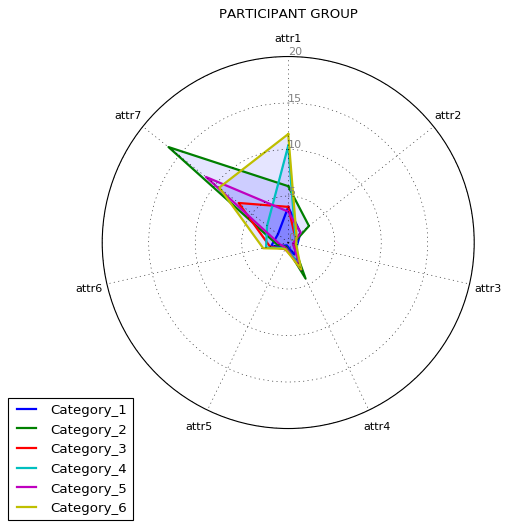

In [297]:
# 由类簇平均半径知k=6最合适
clf = KMeans(n_clusters=6)
s = clf.fit(features)
cluster_centers = clf.cluster_centers_

from math import pi
pd_cluster_centers = pd.DataFrame(cluster_centers)
columns = ['attr1','attr2','attr3','attr4','attr5','attr6','attr7']
pd_cluster_centers.columns = columns
# ------- PART 1: Create background
# number of variable
categories=list(pd_cluster_centers)
N = len(categories)
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
# Initialise the spider plot
plt.figure(figsize=(6,6),dpi=80)
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0,5,10,15,20], ["0","5","10","15","20"], color="grey", size=10)
plt.ylim(0,20)
pd_cluster_centers['Category'] = ["Category_1","Category_2","Category_3","Category_4","Category_5","Category_6"]
print(pd_cluster_centers)
# ------- PART 2: Add plots
# 添加客户类型对应的特征指标
for i in range(len(pd_cluster_centers)):
    # Ind1
    values=pd_cluster_centers.iloc[i:i+1,0:N].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=pd_cluster_centers.iloc[i:i+1,N:N+1].values[0][0])
    ax.fill(angles, values, 'b', alpha=0.1)
    ax.set_title('PARTICIPANT GROUP\n')
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

Tips：
- 数据文件中属性1至7的取值范围分别是：  
1-15　　a-f　　0/1　　a0-a6　　0/1　　C0-C3　　S0-S24
- 下面分析的描述基于“数字越高，等级越高”的假设


分析：
- 第一类attr3以1为主，attr5趋向0，attr4和attr7都是所有类别中等级最低的，attr1、attr2、attr6等级也都偏低
- 第二类attr3和attr5 0、1倾向都不明显，attr2、attr4、attr7均是所有类别中等级最高的，attr1、attr6等级都是中等
- 第三类attr3和attr5都趋向1，attr2是所有类别中等级最低的，attr1、attr4、attr6、attr7等级都是中等
- 第四类attr3趋向1，attr5 0、1倾向不明显，attr2、attr4、attr7等级都偏低，但是attr1、attr6等级都偏高
- 第五类attr3和attr5 0、1倾向都不明显，attr1和attr6都是所有类别中等级最低的，但是attr2、attr4、attr7等级都偏高
- 第六类attr3和attr5都趋向1，attr1是所有类别中等级最高的，除attr2外，attr4、attr6、attr7等级也都偏高

<a id='topic'></a>
### 3.3 参与者对各主题关注比较

#### 以职位为维度，对不同主题的关注度进行比较

In [298]:
f=open("que_key.csv",'r',encoding='utf-8')
df=pd.read_csv(f)
df=np.array(df)

question= pd.read_csv(get_object_storage_file('MyHackathon', 'data2.csv'))
question.head()
question=np.array(question)

question_all = pd.DataFrame()

for i in range(0,5):
    qid=[]
    cnt=[]
    for j in range(0,len(title)):
        if i==title[j]:           
            if question_id[j] not in qid:
                qid.append(question_id[j])
                cnt.append(1)
            else:
                k=0
                while qid[k]!=question_id[j]:
                    k+=1
                cnt[k]+=1
    index=np.array(cnt).argsort()
    
    labels=[]
    quants=[]
    m=1
    while m<=3:
        idx=index[len(index)-m]
        m+=1
        quants.append(cnt[idx])
        id=qid[idx]
        n=0
        while question[n][1]!=id:
            n+=1
        labels.append(df[n][1])

    question_list_tmp = pd.DataFrame(labels)
    question_list_tmp['QUANTS'] = quants
    question_list_tmp['Percentage'] = question_list_tmp.QUANTS/question_list_tmp.QUANTS.sum()
    question_list_tmp['Percentage'] = question_list_tmp.Percentage.apply(lambda x: format(x, '.2%'))
    question_list_tmp.columns = ['LABELS','QUANTS','Percentage']
    question_list_tmp['LABELS_2'] = [','.join(x.split(" ")[1:3]) for x in question_list_tmp.LABELS]
    question_list_tmp['TITLE'] = label[i]
    if i == 0 :
        question_all = question_list_tmp
    else:
        question_all = pd.concat([question_all,question_list_tmp], ignore_index=True)



%brunel data('question_all') bubble color(TITLE,LABELS) size(QUANTS) sort(TITLE) label(LABELS) tooltip(TITLE,Percentage, #all) title('各职位人群关注的主题Top3') style('.label{font-size: 7pt;fill:white;text-shadow:none}') interaction(panzoom) :: width=600, height=400




<IPython.core.display.Javascript object>

Tips:
- 图中每个气泡内表示一个主题，用从主题分析中获得的3个关键词来描述
- 每种颜色表示一类人（这里是同一职位的人）
- 同种颜色的气泡中，气泡越大表示这种职位(用颜色表示)的参与者被关注度越高(关注度以回答该种主题的问题的数量来衡量)
- 关注度是在同一类内比较的
- 鼠标移动到气泡内，可查看职位、关注占比、主题词和具体回答数

分析：
- 从上图中可以看出,Specialist最关注”成功“相关的问题、Engineer最关注“小朋友”相关的问题、Manager最关注“改变”和“工作”
- Consultant由于参与回答的问题数太少，分析意义不大
- 此外，可以发现每种颜色的气泡总大小一定程度上反映了每种职位的参与者回答问题的总数量，这与在3.2中获得的统计图是一致的

#### 以属性为维度（基于聚类结果），对不同主题的关注度进行比较

In [300]:
#获得每一条回答参与者的类别
cluster=[]
for i in range(0,len(clf.labels_)):
    cluster.append(clf.labels_[i])
       
f=open("que_key.csv",'r',encoding='utf-8')
df=pd.read_csv(f)
df=np.array(df)

question= pd.read_csv(get_object_storage_file('MyHackathon', 'data2.csv'))
question.head()
question=np.array(question)

question_all_2 = pd.DataFrame(labels)

for i in range(0,6):
    qid=[]
    cnt=[]
    for j in range(0,len(cluster)):
        if i==cluster[j]:           
            if question_id[j] not in qid:
                qid.append(question_id[j])
                cnt.append(1)
            else:
                k=0
                while qid[k]!=question_id[j]:
                    k+=1
                cnt[k]+=1
    index=np.array(cnt).argsort()
    
    labels=[]
    quants=[]
    m=1
    while m<=10:
        idx=index[len(index)-m]
        m+=1
        quants.append(cnt[idx])
        id=qid[idx]
        n=0
        while question[n][1]!=id:
            n+=1
        labels.append(df[n][1])

    question_list_tmp = pd.DataFrame(labels)
    question_list_tmp['QUANTS'] = quants
    question_list_tmp['Percentage'] = question_list_tmp.QUANTS/question_list_tmp.QUANTS.sum()
    question_list_tmp['Percentage'] = question_list_tmp.Percentage.apply(lambda x: format(x, '.2%'))
    question_list_tmp.columns = ['LABELS','QUANTS','Percentage']
    question_list_tmp['LABELS_2'] = [','.join(x.split(" ")[1:3]) for x in question_list_tmp.LABELS]
    question_list_tmp['Category'] = "Category_" + str(i+1)
    if i == 0 :
        question_all_2 = question_list_tmp
    else:
        question_all_2 = pd.concat([question_all_2,question_list_tmp], ignore_index=True)



%brunel data('question_all_2') bubble color(Category,LABELS) size(QUANTS) sort(Category) label(LABELS) tooltip(Category,Percentage, #all) title('各类别人群关注的主题Top10') style('.label{font-size: 7pt;fill:white;text-shadow:none}') interaction(panzoom) :: width=600, height=400



<IPython.core.display.Javascript object>

分析：
- 从上图中可以看出,属于类别1和类别3的参与者都最关注”工作“相关的问题、属于类别2和类别5的参与者都最关注“成功”相关的问题、而属于类别4和类别6的参与者最关注“小朋友“相关的问题
- 每种颜色的气泡总大小可以一定程度上反映每种类别的参与者回答问题的总数量，类别4的参与者回答数量最少

<a id='process'></a>
# 4. 数据处理
本节为情感分析做准备，对所有回答进行预处理

<a id='clean'></a>
### 4.1 数据转换和分词
- 有些停用词,如”呵呵“也会有情感倾向，所以情感分析时无需对数据过滤停用词
- 统一所有汉字为简体字  
eg.

In [288]:
df_data_1 = pd.read_csv(get_object_storage_file('MyHackathon', 'data_label.csv'))
df_data_1.head()
data = np.array(df_data_1)
question=[]
label=[]
print (data[4][1])

for i in range(0,len(data)):
    label.append(data[i][0])
    question.append(Converter('zh-hans').convert(data[i][1]))
    
#数据预处理
corpus=[]                   
for line in question:
    #分词
    seg_generator = jieba.cut(line)
    seg_list = [i for i in seg_generator]
    seg_list = r' '.join(seg_list)
    corpus.append(seg_list.strip())
print ("预处理后：",corpus[4])


你覺得這次使用API來回答問題的活動怎麼樣? 有culture transformation的感覺嗎?
预处理后： 你 觉得 这次 使用 API 来 回答 问题 的 活动 怎么样 ?   有 culture   transformation 的 感觉 吗 ?


<a id='svm'></a>
### 4.2 SVM分类算法，对问题进行分类
- 对所有问题进行人工标记，训练出一个分类模型
- 将问题分为1-非开放性 和 2-开放性两类
- 开放性问题是一些不能那么轻易地只用一个简单的“是”、“不是”的问题，需要回答者对有关事情做进一步的描述

In [289]:
#词频矩阵
vectorizer = CountVectorizer()
#fit_transform是将文本转为词频矩阵
X = vectorizer.fit_transform(corpus)
y=label

X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)  
clf = SVC(kernel = 'linear')
clf.fit(X_train,y_train)  
print ('分类器准确率')
print (clf.score(X_test,y_test))

分类器准确率
0.857142857143


<a id='filter'></a>
### 4.3 开放性问题过滤
- 开放性问题因其趋向于对一个问题发表看法和描述，情感倾向不明显，所以通常不用于情感分析
- 只针对非开放性问题进行情感分析

In [290]:
df_data_1 = pd.read_csv(get_object_storage_file('MyHackathon', 'data_label.csv'))
df_data_1.head()
data = np.array(df_data_1)
question=[]
label=[]
for i in range(0,len(data)):
    label.append(data[i][0])
    question.append(data[i][1])

In [291]:
# 获得问题和答案两列数据，并将繁体转为简体
answer=[]
df_data= pd.read_csv(get_object_storage_file('MyHackathon', 'answer.csv'))
df_data.head()
data = np.array(df_data)
for i in range(0,len(data)):
    question=[]
    question.append(data[i][0])
    question.append(data[i][3])
    question.append(Converter('zh-hans').convert(data[i][1]))
    question.append(Converter('zh-hans').convert(data[i][4]))
    answer.append(question)
answer=np.array(answer)

# 获得问题分类，并将繁体转为简体
df_data= pd.read_csv(get_object_storage_file('MyHackathon', 'data_label.csv'))
df_data.head()
df_data = np.array(df_data)
answer_label=[]
for i in range(0,len(df_data)):
    data=[]
    data.append(df_data[i][0])
    data.append(Converter('zh-hans').convert(df_data[i][1]))
    answer_label.append(data)
answer_label=np.array(answer_label)

questions=[]
labels=[]
for label in answer_label:
    labels.append(label[0])
    questions.append(label[1])

# 从问题中提取非开放性问题
simple=[]
simple_aid=[]
simple_qid=[]
for ans in answer:
    sim=ans[2]
    for i in range(0,len(questions)):
        if sim==questions[i] and labels[i]=='1':
            simple_qid.append(ans[0])
            simple_aid.append(ans[1])          
            s=[]
            s.append(ans[2])
            s.append(ans[3])
            simple.append(s)
            break

print ("\n5个用于情感分析的问题及回答\n")
for i in range(0,25,5):
    print (simple[i][0],simple[i][1])


5个用于情感分析的问题及回答

Do you like our new Agile Open Office? Yes
我们新装修的Agile workspace， 你觉得还有味吗？ yes
Do you like our new Agile Open Office? 还可以吧
Do you love IBM? Ya. Once an IBMer,always an IBMer.
你觉得这个OpenWhisk好用吗？ 还可以，要是try it out之后的结果更突出显示就更好了。我打开的section有点多，一不小心会看错


<a id='model'></a>
# 5. 模型构建

<a id='dict'></a>
### 5.1 中英文情感词、否定词、程度词库导入
- 中文情感词库来自大连理工大学信息检索研究室
- 其余词库来自知网

In [292]:
#(1)情感词
pos=[]
neg=[]
pos_weight=[]
neg_weight=[]
df_data= pd.read_csv(get_object_storage_file('MyHackathon', 'pos_neg.csv'))
data = np.array(df_data)
for i in range(0,len(data)): 
    if data[i][4].startswith('P') and data[i][3]==1:  
        pos.append(data[i][0])
        pos_weight.append(data[i][5])
    elif data[i][4].startswith('N') and data[i][3]==1:
        neg.append(data[i][0])
        neg_weight.append(data[i][5])

df_data= pd.read_csv(get_object_storage_file('MyHackathon', 'pos_eng.csv'))
df_data = np.array(df_data)
for i in range(0,len(df_data)):
    pos.append(df_data[i][0].replace(' ',''))
    pos_weight.append(5.0)

df_data= pd.read_csv(get_object_storage_file('MyHackathon', 'neg_eng.csv'))
df_data = np.array(df_data)
for i in range(0,len(df_data)):
    neg.append(df_data[i][0].replace(' ',''))
    neg_weight.append(5.0)

print ("部分正向情感词:")
print (pos[0],pos[50],pos[-100],pos[-200],'\n')
print ("部分负向情感词:")
print (neg[0],neg[50],neg[-50],neg[-200],'\n')

# (2)否定词
notList=[]
df_data= pd.read_csv(get_object_storage_file('MyHackathon', 'notList.csv'))
df_data = np.array(df_data)
for i in range(0,len(df_data)):
    notList.append(df_data[i][0].replace(' ',''))
print ("部分否定词:")
print (notList[0],notList[1],notList[2],notList[3],'\n')

# （3）程度副词
deg_chi_w=[]
deg_chi=[]
df_data= pd.read_csv(get_object_storage_file('MyHackathon', 'deg_chi.csv'))
df_data = np.array(df_data)
for i in range(0,len(df_data)):
    deg_chi_w.append(df_data[i][0])
    deg_chi.append(df_data[i][1])
deg_eng_w=[]
deg_eng=[]
df_data= pd.read_csv(get_object_storage_file('MyHackathon', 'deg_eng.csv'))
df_data = np.array(df_data)
for i in range(0,len(df_data)):
    deg_eng_w.append(df_data[i][0])
    deg_eng.append(df_data[i][1])
    
print ("部分程度情感词:")
print (deg_chi_w[0],deg_chi_w[10],deg_eng_w[0],deg_eng_w[5])

部分正向情感词:
清峻 优厚 wise warmheartedly 

部分负向情感词:
脏乱 风刀霜剑 vacillate satire 

部分否定词:
没 无 非 莫 

部分程度情感词:
倍加 地地道道 absolute astonishingly


<a id='sentiment'></a>
### 5.2 情感聚合
- 情感词，情感强度分为1,3,5,7,9五档，9表示强度最大，1为强度最小
- 程度副词，情感强度分为1,2,3,4四档,4表示强度最大，1为强度最小
- 扫描每个回答，以句子为单位匹配词库
- 情感正向词为加分，情感负向词为减分
- 情感得分为句子中所有包含的情感词强度及其程度副词的强度之积的总和
- 如果遇到否定词，则从否定词开始一直到这句话结束，所有情感词得分都乘一次-1（表示情感反向一次），双重否定为(-1)^2=1，语义保持不变，与现实相符
- 对于一句中重复出现的情感词，只计1次
- 情感打分的几个例子：

In [293]:
# 过滤停用词
com_stop_word=[]
df_data= pd.read_csv(get_object_storage_file('MyHackathon', 'com_stop_list.csv'))
df_data = np.array(df_data)
for i in range(0,len(df_data)):
    com_stop_word.append(df_data[i][0])  

#要打印的示例句子
print_list={0,8,12,30}

# 情感打分
scores=[]
for i in range(0,len(simple)):
    sentence=[]
    score=0
    W=1
    # 记录出现的词语，相同的情感词只计一次
    used=[]
    if i in print_list:
        print ('要分析的问题及回答：',simple[i])    
    seg_generator = jieba.cut(simple[i][1])  
    #筛出stop word
    seg_list = [j for j in seg_generator if j not in com_stop_word and j != ' ']
    k=0
    while k<len(seg_list):
        word=seg_list[k].lower()
        jump=1
        
        # 是否是否定词
        if word in notList:
            if i in print_list:
                print (word,"否定词")
            W*=-1 
        # 是否是情感词
        elif word in pos:          
            for n in range(0,len(pos)):
                if pos[n]==word and word not in used:
                    if i in print_list:
                        print (word,"正向词","情感强度:",pos_weight[n])
                    used.append(word)
                    score+=W*pos_weight[n]
                    W=1
        elif word in neg:          
            for n in range(0,len(neg),):
                if neg[n]==word and word not in used:
                    if i in print_list:
                        print (word,"负向词","情感强度:",neg_weight[n])
                    used.append(word)
                    score-=W*neg_weight[n]
                    W=1

        # 判断是否是程度副词
        # 中文直接查表
        elif not word.encode( 'UTF-8' ).isalpha():
            l=0
            while l<len(deg_chi_w):
#                 print (deg_chi_w[l])
                if word==deg_chi_w[l]:
                    W*=deg_chi[l]
                    if i in print_list:
                        print (word,"程度副词","强度:",deg_chi[l])
                    break
                else:
                    l+=1
        # 英文词组匹配
        else:
            m=0  
            flag=0
            while m<len(deg_eng_w) and flag==0:
                deg_words=deg_eng_w[m].split(' ')
#                 print (simple[i][1],word,deg_eng_w[m],len(deg_words),len(seg_list))
                phrase=word   
                if k+len(deg_words)<=len(seg_list): 
                    count=1
                    while count<len(deg_words): 
                        phrase=phrase+' '+seg_list[k+count].lower()
                        count+=1   
                    if phrase==deg_eng_w[m]:
                        W*=deg_eng[m]
                        flag=1
                        jump=len(phrase.split(' '))
                        if i in print_list:
                            print (word,"程度副词","强度:",deg_chi[m])
                m+=1             
        k+=jump 
    scores.append(score)
    if i in print_list:
        print ("score",score,'\n')

要分析的问题及回答： ['Do you like our new Agile Open Office?', 'Yes']
yes 正向词 情感强度: 5.0
score 5.0 

要分析的问题及回答： ['你觉得这个OpenWhisk好用吗？', 'bulemix上call API不是很方便，要自己编辑参数']
不是 否定词
很 程度副词 强度: 3
方便 正向词 情感强度: 5
score -15 

要分析的问题及回答： ['Do you like our new Agile Open Office?', 'I do not like it.']
not 否定词
like 正向词 情感强度: 5.0
score -5.0 

要分析的问题及回答： ['Do you like our new Agile Open Office?', "Yes, it's very impressive"]
yes 正向词 情感强度: 5.0
very 程度副词 强度: 3
impressive 正向词 情感强度: 5.0
score 20.0 



<a id='analysis'></a>
### 5.3 一个具体问题的情感分数统计
因非开放性问题中回答数量第二多的问题只有7条回答，所以只对回答数量最多(40条)的一个非开放性问题进行情感分数的统计分析:

In [294]:
# 找到回答数最多的question_id

txt=[]
ques=[]
cnt=[]
for i in range(0,len(simple)):
    txt.append(simple[i][0])
    que=simple_qid[i]
    if que not in ques:
        ques.append(que)
        cnt.append(1)
    else:
        j=0
        while ques[j]!=que:
            j+=1
        cnt[j]+=1

max_simple=ques[np.array(cnt).argsort()[len(ques)-1]]
print (txt[np.array(cnt).argsort()[len(ques)-1]])

Do you like our new Agile Open Office?


#### 以职位为维度，进行情感倾向比较

In [295]:
# 对情感分数>0 =0 <0 分别计数
x=[]
y=[]
rst_item = ['Good','Neutral','Bad']
label=['Manager','Engineer','Specialist','Consultant','Other']
for i in range(0,5):
    pos=0
    mid=0
    neg=0
    for j in range(0,len(question_id)):
        if title[j]==i and question_id[j]==max_simple and answer_id[j] in simple_aid:
            k=0
            while simple_aid[k]!=answer_id[j]:
                k+=1
            score=scores[k]
            if score>0:
                pos+=1
            elif score==0:
                mid+=1
            else:
                neg+=1
    x.append([pos,mid,neg])
    y.append(label[i])

pd_data1 = pd.DataFrame()
for index_1 in range(len(x)):
    pd_tmp = pd.DataFrame(x[index_1],columns=['VALUE'])
    pd_tmp['TYPE'] = y[index_1]
    pd_tmp['ITEM'] = rst_item
    pd_data1 = pd.concat([pd_data1,pd_tmp])

%brunel data('pd_data1') bar x(TYPE) y(VALUE) sum(VALUE) color(ITEM) label(ITEM,':',VALUE) tooltip(#all) stack style('.label{fill:white;text-shadow:none}') bar interaction(select:mouseover)   effect(enter:2000)  title("不同职位对应的情感分析分布")  axes(y:2000:grid:"数量",x:10:"类别"):: width=800, height=300

    


<IPython.core.display.Javascript object>

分析：
- Engineer对”Do you like our new Agile Open Office?“这一问题持有的态度最积极，同时也是回答数最多的，Manager次之
- Consultant对该问题持有的态度最消极,回答数也最少
- Specialist更倾向于持中立态度

#### 以属性为维度（基于聚类结果），进行情感倾向比较

In [296]:
x=[]
y=[]
for i in range(0,6):
    pos=0
    mid=0
    neg=0
    for j in range(0,len(question_id)):
        if cluster[j]==i and question_id[j]==max_simple and answer_id[j] in simple_aid:
            k=0
            while simple_aid[k]!=answer_id[j]:
                k+=1
            score=scores[k]
            if score>0:
                pos+=1
            elif score==0:
                mid+=1
            else:
                neg+=1
    x.append([pos,mid,neg])
    y.append(i)
     
pd_data2 = pd.DataFrame()
for index_2 in range(len(x)):
    pd_tmp = pd.DataFrame(x[index_2],columns=['VALUE'])
    pd_tmp['TYPE'] = "Category_" + str(y[index_2]+1)
    pd_tmp['ITEM'] = rst_item
    pd_data2 = pd.concat([pd_data2,pd_tmp])


%brunel data('pd_data2') bar x(TYPE) y(VALUE) sum(VALUE) label(ITEM,':',VALUE) color(ITEM) tooltip(#all) stack style('.label{fill:white;text-shadow:none}') bar interaction(select:mouseover)   effect(enter:2000)  title("不同类别人群对应的情感分析分布")  axes(y:2000:grid:"数量",x:10:"类别"):: width=800, height=300



<IPython.core.display.Javascript object>

分析：
- 类别1对”Do you like our new Agile Open Office?“这一问题持有的态度最积极，类别2次之，这两类人也是回答数最多的
- 类别3对该问题持有的态度较为积极或中立，少有负面评价
- 类别5更倾向于持中立态度
- 类别4和类别6没有参与该问题的回答，从统计图中”回答数越多，态度越积极“的发现可以推测，这两类人群对于该问题持有的态度偏消极

### 作者
**颜 晓超** IBM数据分析高级分析师，有丰富的针对企业客户开发和提供各类数据分析服务经验  
**顾 彬**   IBM数据分析高级分析师，有丰富的针对企业客户开发和提供各类数据分析服务经验  
**徐 璠斐** IBM数据分析实习生

<div><br><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png" width = 200 height = 200>
</div><br>